# Tutorial 2: Analyzing Statistics and Variogram of the Ice Stream Data

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import sys
sys.path.append('..')
from gstatsmcmc import Topography
from gstatsmcmc import MCMC
import gstatsim as gs

### First load data

The code is tested by a cropped region for shorter running time

In [21]:
# load compiled bed elevation measurements
df = pd.read_csv('../data/BindSchalder_Macayeal_IceStreams.csv')

In [22]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [23]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)
bedmachine_bed = bedmap_surf - bedmachine_thickness

### Now, it is the time to analyze the compiled radar data.

#### Fit variogram

MCMC.fit_variogram is a wrapper around functions in scikit-learn and skgstats python modules. It conveniently normalize the provided bed elevation data, calculate the semi-variogram, and fit it with four different models (Gaussian, Exponential, Spherical, Matern). The output map could be used to visually decide which variogram model fit the data the best.

In [24]:
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

range, sill, and nugget for gaussian variogram is  [41416.80096871535, 0.7794384572942589, 0]
for exponential variogram is  [80397.13320725446, 0.8680050144653642, 0]
for spherical variogram is  [53719.34229546759, 0.7947477746708957, 0]
range, sill, smoothness, and nugget for for matern variogram is  [86144.91814481204, 0.8846579908358188, 0.39590955240731646, 0]


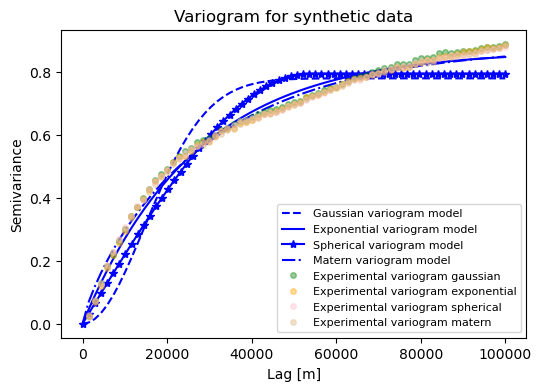

In [30]:
# find variograms
df_bed = df.copy()
df_bed = df_bed[df_bed["cond_bed"].isnull() == False]
data = df_bed['cond_bed'].values.reshape(-1,1)
coords = df_bed[['x','y']].values
roughness_region_mask = (df_bed['bedmap_mask'].values)==1 # Read BedMap paper for the meaning of values == 1
nst_trans, Nbed_radar, varios, fig = MCMC.fit_variogram(data, coords, roughness_region_mask, 
                                                        maxlag=100000, n_lags=70, samples = 0.10)

__Q1: How does the maxlag and n_lags affect variogram calculated? How you determine their values such that your variogram is accurately represented?__



__Q2: Which variogram model you choose? Why?__

I would choose the matern or Exponential model because it closely fits the experimentals. The Gaussian seems to be the wrost fit because it rises steelpy and flattens very quickly, as seen in its low range and relatively similar sills to other models. 

#### Generate initial bed

Let's generate a SGS bed for the entire region

https://gatorglaciology.github.io/gstatsimbook/4_Sequential_Gaussian_Simulation.html 

In [48]:
varios

[[41416.80096871535, 0.7794384572942589, 0],
 [80397.13320725446, 0.8680050144653642, 0],
 [53719.34229546759, 0.7947477746708957, 0],
 [86144.91814481204, 0.8846579908358188, 0.39590955240731646, 0]]

In [ ]:
np.save('2_nst_transformed.npy',nst_trans)
np.save('2_nbed_radar.npy', Nbed_radar)
np.save('2_varios.npy', np.array(varios, dtype=object))

In [26]:

# MUST add allow_pickle=True to load an object array
various_array = np.load('2_varios.npy', allow_pickle=True)
nst_trans = np.load('2_nst_transformed.npy', allow_pickle=True)
Nbed_radar = np.load('2_nbed_radar.npy', allow_pickle=True)

In [27]:
(xx.flatten(),yy.flatten())
type(various_array[3])

list

In [ ]:
k = 48
rad = 50000
matern = various_array[3]
# [azimuth, nugget, major_range, minor_range, sill, vtype] for anything not Matern 
# [azimuth, nugget, major_range, minor_range, sill, vtype, smoothness] for Matern 
vario = [0, 0, matern[0], matern[0], matern[1], 'Matern', matern[2]]

Pred_grid_xy = df[['x','y']].values

df_bed['Nbed'] = Nbed_radar.flatten()

sim = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_bed, 'x', 'y', 'Nbed', k, vario, rad)
np.save("interpolation_sim_2.npy", sim)



100%|██████████| 1193314/1193314 [15:10:26<00:00, 21.85it/s]  


In [ ]:
np.save("interpolation_sim_2.npy", sim)

In [53]:
sgs_bed = nst_trans.inverse_transform(sim.reshape(-1,1)).reshape(xx.shape)
np.savetxt('sgs_bed_bindshalder.txt',sgs_bed)

SGS only generate a realization of the bed topography according to the known radar measurements. However, it might ignored something else. The thickness of the ice can be calculated as ice surface elevation minus bed elevation. From BedMachine, we know where the land is ice-free and where is covered by ice. However, SGS might generate bed such that it 'extrude' out of ice in the supposed grounded ice region. Let's fix that quickly

In [28]:
sim = np.load('interpolation_sim_2.npy')
sgs_bed = np.loadtxt('sgs_bed_bindshalder.txt')

In [29]:
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

There are other things we would like to record before begin the MCMC chains

In [30]:
cond_bed = df['cond_bed'].values.reshape(xx.shape)
data_mask = ~np.isnan(cond_bed)

(-997500.0, -408500.0, -1057000.0, -550500.0)

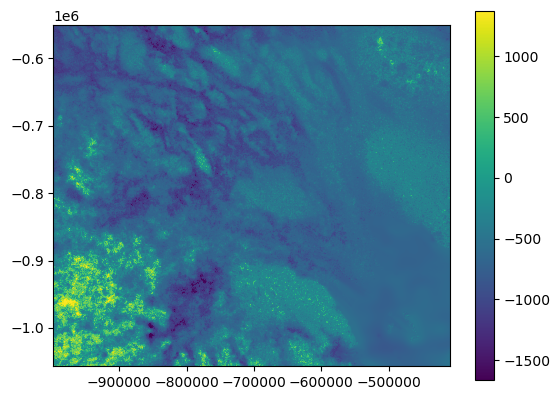

In [31]:
plt.pcolormesh(xx,yy,sgs_bed)
plt.colorbar()
plt.axis('scaled')

(0.0, 1178.0, 0.0, 1013.0)

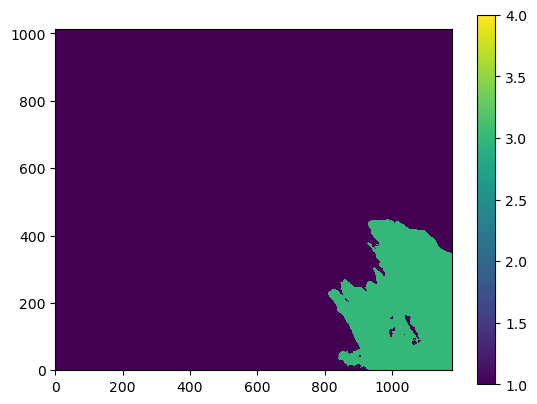

In [32]:
plt.pcolormesh(bedmap_mask)
plt.colorbar()
plt.axis('scaled')

(-997500.0, -408500.0, -1057000.0, -550500.0)

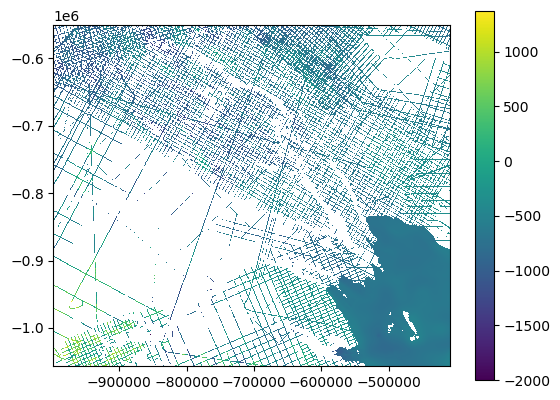

In [33]:
plt.pcolormesh(xx,yy,cond_bed)
plt.colorbar()
plt.axis('scaled')

(0.0, 1178.0, 0.0, 1013.0)

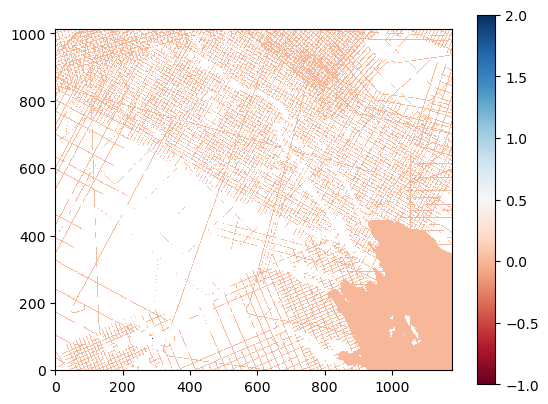

In [37]:
plt.pcolormesh(sgs_bed - cond_bed,vmax=2,vmin=-1,cmap='RdBu')
plt.colorbar()
plt.axis('scaled')